In [2]:
# Import necessary modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [3]:
# Import data 

# Read the CSV file into a DataFrame: df
df = pd.read_csv('existingproductattributes2017.csv')
df = df.drop('ProductNum', axis=1)
# Create dummy variables with drop_first=True: df_region
df = pd.get_dummies(df,drop_first=True)

# Print the new columns of df_region
print(df.columns)

Index(['Price', 'x5StarReviews', 'x4StarReviews', 'x3StarReviews',
       'x2StarReviews', 'x1StarReviews', 'PositiveServiceReview',
       'NegativeServiceReview', 'Recommendproduct', 'BestSellersRank',
       'ShippingWeight', 'ProductDepth', 'ProductWidth', 'ProductHeight',
       'ProfitMargin', 'Volume', 'ProductType_Display',
       'ProductType_ExtendedWarranty', 'ProductType_GameConsole',
       'ProductType_Laptop', 'ProductType_Netbook', 'ProductType_PC',
       'ProductType_Printer', 'ProductType_PrinterSupplies',
       'ProductType_Smartphone', 'ProductType_Software', 'ProductType_Tablet'],
      dtype='object')


# XGBRegressor

In [4]:
# Create arrays for the features and the target: X, y
X, y = df.iloc[:,:-1], df.iloc[:,-1]

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:linear"}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain= DM_train, params =params, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))


RMSE: 0.115310


In [5]:
# save the model
pickle.dump(xg_reg, open("xg_reg.pkl", "wb"))
xg_reg2 = pickle.load(open("xg_reg.pkl", "rb"))

# XGBRegressor with cross-validation

In [6]:
# Create the DMatrix: housing_dmatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results =xgb.cv(dtrain=dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

# Using regularization in XGBoost

In [7]:
reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:linear","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse =xgb.cv(dtrain=dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))


[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[01:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

# Visualizing individual XGBoost trees

In [18]:
# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)


[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[02:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

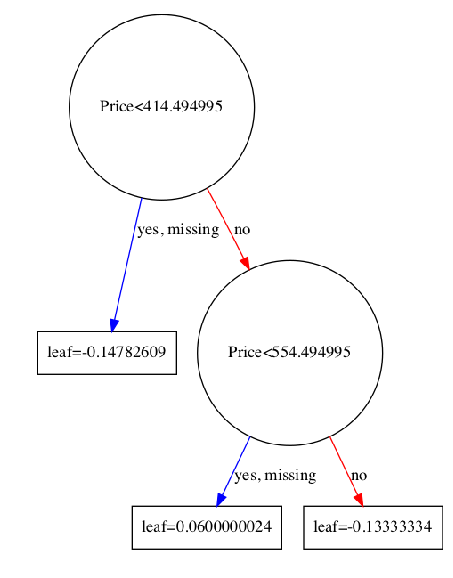

In [19]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

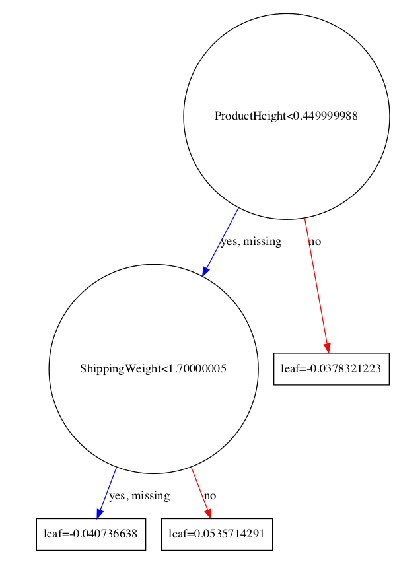

In [16]:
# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

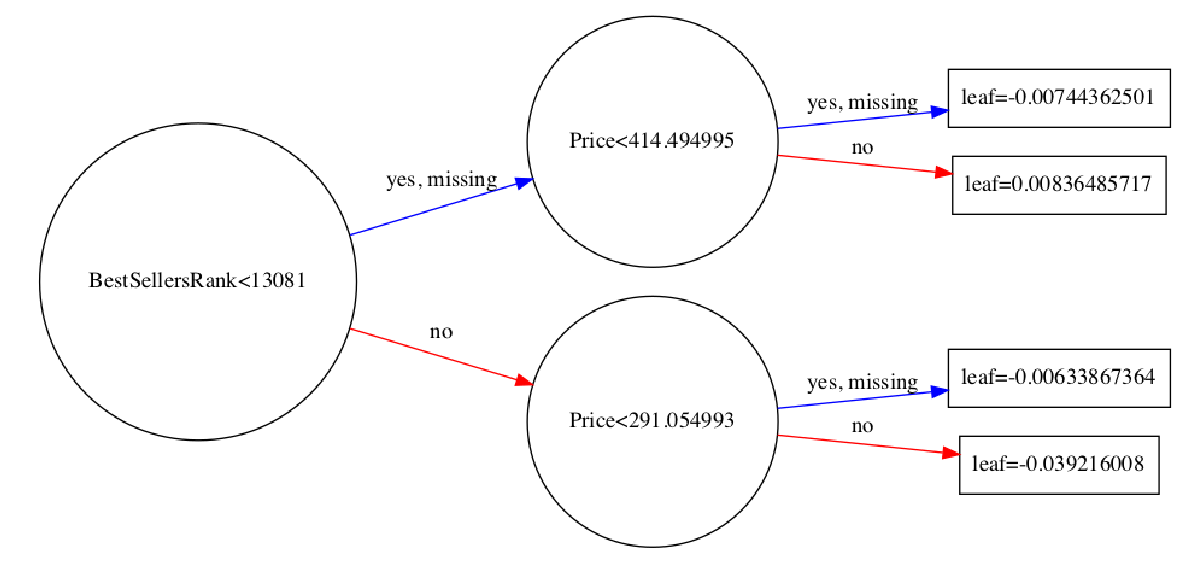

In [15]:
# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9,rankdir="LR")
plt.show()

# Visualizing feature importances

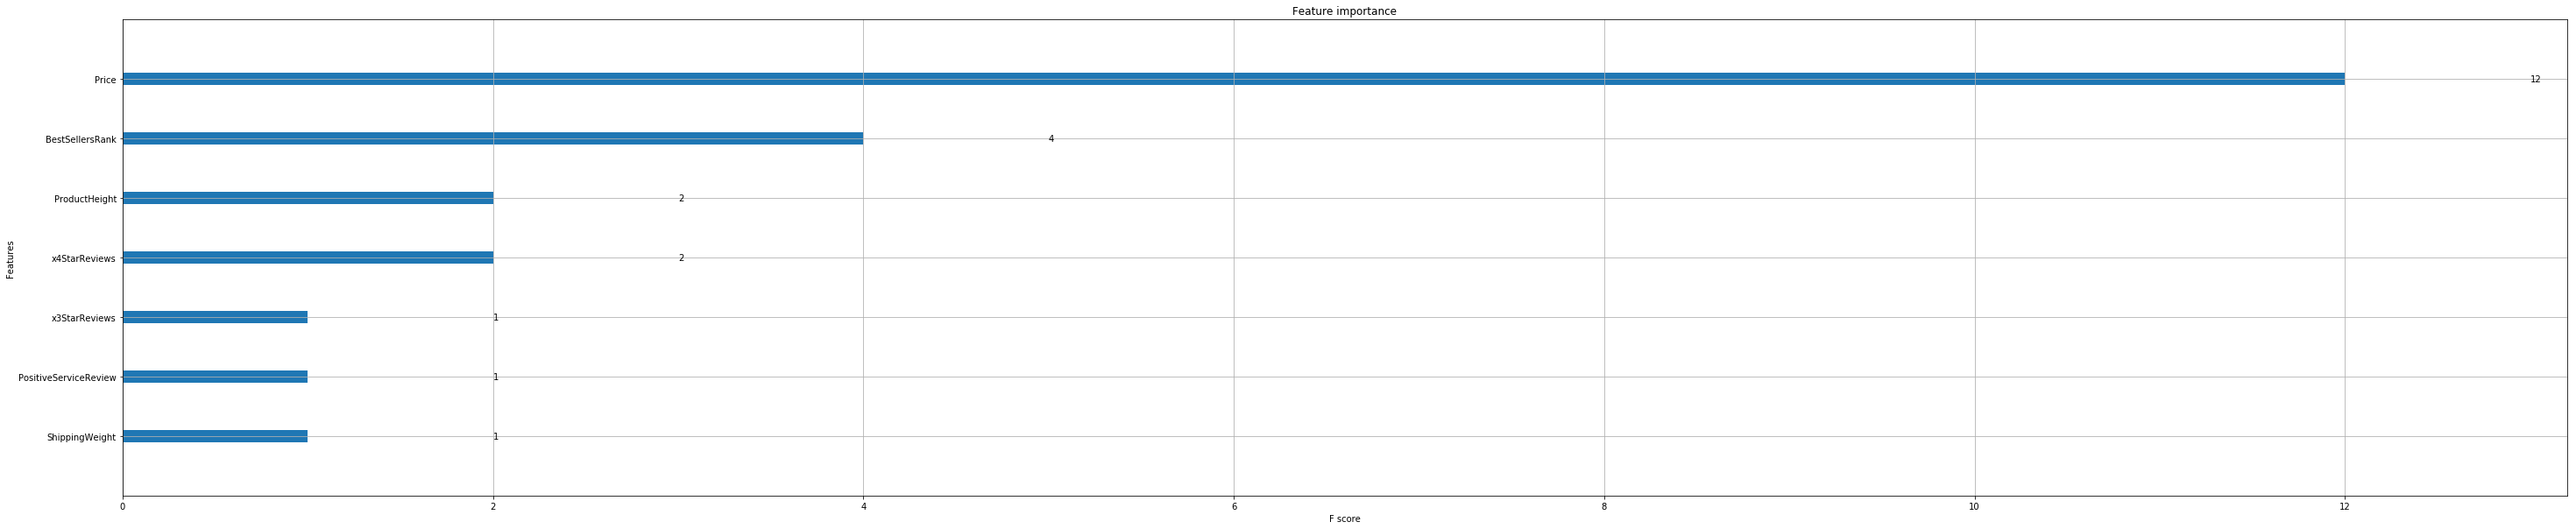

In [22]:
# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 20]
plt.show()


# Tuning the number of boosting rounds

In [23]:
# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))


[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

# Automated boosting round selection using early_stopping

In [24]:
# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=dmatrix,params=params,early_stopping_rounds=10,num_boost_round=50)

# Print cv_results
print(cv_results)

[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

# Tuning eta

In [25]:
# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals= [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results =xgb.cv(dtrain=dmatrix,params=params,early_stopping_rounds=10,num_boost_round=50,metrics="rmse", as_pandas=True, seed=123)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
     eta  best_rmse
0  0.001   0.478939
1  0.010   0.335118
2  0.100   0.175357


# Tuning max_depth

In [26]:
#####Smaller values will lead to shallower trees, and larger values to deeper trees.

# Create list of max_depth values
max_depths =  [2,5,10,20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] =curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=dmatrix,params=params,nfold=2, early_stopping_rounds=5,num_boost_round=50,metrics="rmse", as_pandas=True, seed=123)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))


[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_dept

[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:12:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[

# Tuning colsample_bytree 

In [27]:
# Create list of hyperparameter values: colsample_bytree_vals
colsample_bytree_vals = [0.1,0.5,0.8,1]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[

# Grid Search with XGBoost

In [28]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2,5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring="neg_mean_squared_error",cv=4,verbose=1)


# Fit grid_mse to the data
grid_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.3, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found:  0.20573714088111114


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished


# Random Search with XGBoost

In [30]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid,scoring="neg_mean_squared_error",n_iter=5,cv=4,verbose=1)


# Fit randomized_mse to the data
randomized_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))


Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 25, 'max_depth': 2}
Lowest RMSE found:  0.21892753436591125


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished
